## Lab | Customer Analysis Round 7

#### Importing all the required libraries:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Getting the dataframe from the CSV file:

In [6]:
data = pd.read_csv('/Users/Hector_Martin/Documents/Labs/Linear Regression/lab-customer-analysis-round-7/files_for_lab/csv_files/marketing_customer_analysis.csv')
data = data.drop(['Customer', 'Effective To Date'], axis =1)

#Creating a copy of the Dataframe to work with it:
datasafe = data.copy()
datasafe.head()


,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,No,Premium,Bachelor,Employed,F,48767,Suburban,Married,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,No,Basic,Bachelor,Unemployed,M,0,Suburban,Married,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,No,Basic,Bachelor,Employed,M,43836,Rural,Single,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


#### Splitting the dataframe between Numerical and Categorical data:

#### Use the concept of multicollinearity and remove insignificant variables:

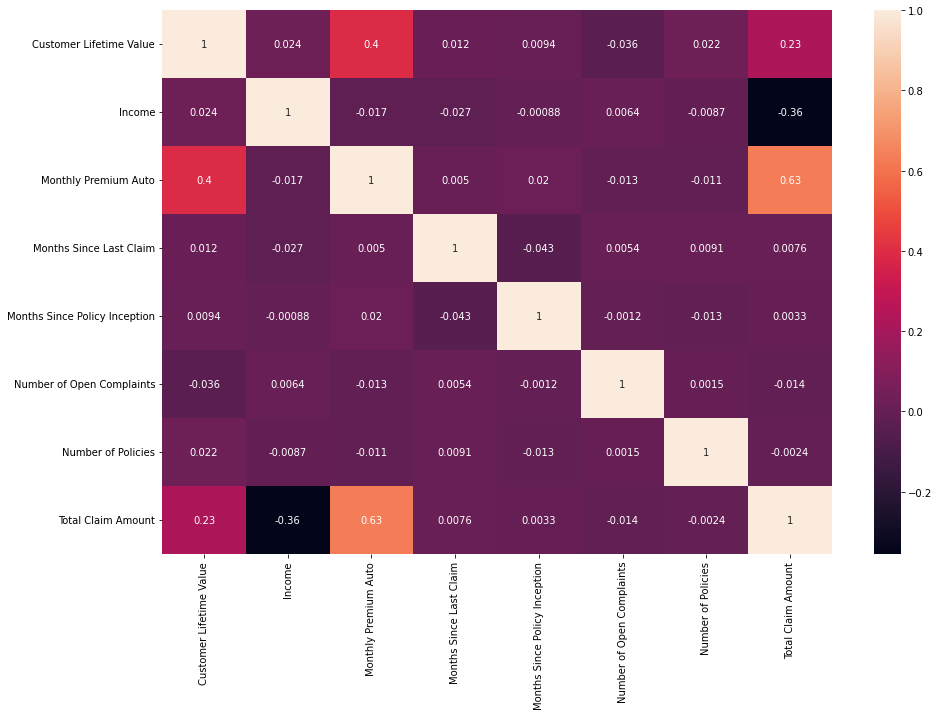

In [7]:
#We will plot a Heatmap and remove those columns that have a correlation higher than 0.9.
#This is done to remove redundant information from the dataframe.

corr_num = datasafe.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr_num, annot=True)
plt.show()

No column was finally removed because no variable displayed a correlation higher than 0.9

### X-y Split: 

In [8]:
X = datasafe.drop(['Total Claim Amount'], axis = 1)
y = datasafe[['Total Claim Amount']]

In [9]:
print(y.shape)
print(X.shape)

(9134, 1)
(9134, 21)


In [10]:
X_numerical = datasafe.select_dtypes(include= np.number)
X_categorical = datasafe.select_dtypes(include = object)

### Checking the distribution on y:

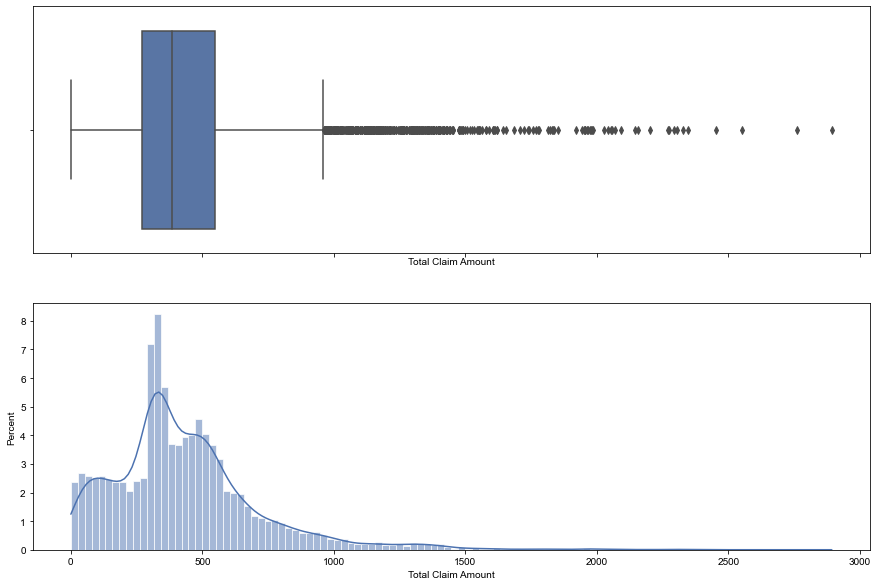

In [11]:
#After using a Box plot we can see that the dataframe

#'sharex' allows us to have 2 plots that share the X axis
# As we can see, the distribution is positively skewed and highly populated by outliers
# For the sake of practicing, let's apply a Log Transformation and also remove the aforementioned outliers:

fig, axis = plt.subplots(2,1,sharex=True, figsize=(15,10))

sns.set_theme(style="whitegrid")
sns.boxplot(x = y['Total Claim Amount'],ax = axis[0]);
sns.histplot(x = y['Total Claim Amount'],ax = axis[1], kde=True, stat="percent");
plt.show()

#### Let's start with the Log Transform to correct part of the Positive skew:

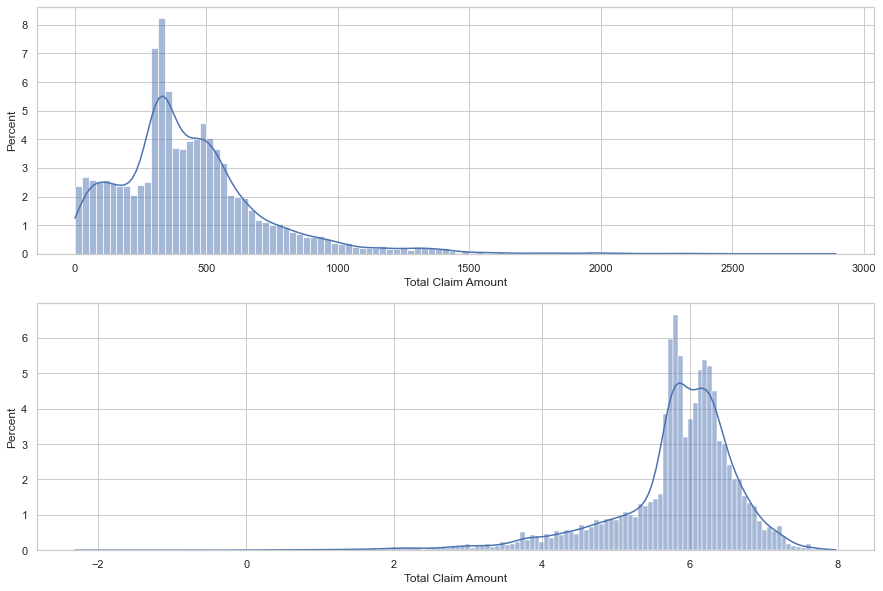

In [12]:
def log_transfom_clean2(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

# We are transforming all those infinite values that we are getting after applying the Log Transformation and getting
# and replacing those with the Mean of the variable we are transforming
# We are going to create a copy as well so we won't overide any information

y_copy = y.copy()
y_copy['Total Claim Amount'] = list(map(log_transfom_clean2, y_copy['Total Claim Amount']))

#we will apply those indexes in all the Dataframes we have got
#so we will not have any undesired NaNs after concatenating them

y_copy['Total Claim Amount'] = y_copy['Total Claim Amount'].fillna(np.mean(y_copy['Total Claim Amount']))

#Let's compare how the distribution looks so far:

fig, axis = plt.subplots(2,1, figsize=(15,10))
sns.set_theme(style="whitegrid")
sns.histplot(x = y['Total Claim Amount'], ax = axis[0], kde=True, stat="percent");
sns.histplot(x = y_copy['Total Claim Amount'], ax = axis[1], kde=True, stat="percent");
plt.show()

Now the distribution is starting to look more Gaussian

#### Now let's remove the outliers:

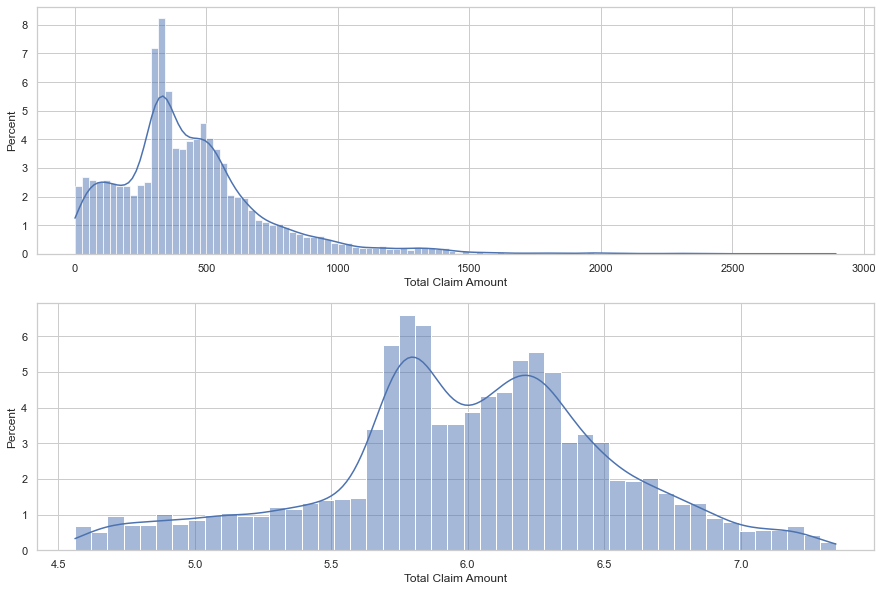

In [13]:
iqr = np.percentile(y_copy,75) - np.percentile(y_copy,25)
upper_limit = np.percentile(y_copy['Total Claim Amount'],75) + 1.5*iqr
lower_limit = np.percentile(y_copy['Total Claim Amount'],25) - 1.5*iqr

y_copy = y_copy[(y_copy['Total Claim Amount'] >lower_limit) & (y_copy['Total Claim Amount'] <upper_limit)]

#Getting the indexes of the rows after removing the Outliers, we will apply those to X
#So we will not have any issues when applying the Linear Regression:
rows_to_keep = y_copy[(y_copy['Total Claim Amount'] >lower_limit) & (y_copy['Total Claim Amount'] <upper_limit)].index

#Now let's compare again the distributions:
fig, axis = plt.subplots(2,1, figsize=(15,10))
sns.set_theme(style="whitegrid")
sns.histplot(x = y['Total Claim Amount'], ax = axis[0], kde=True, stat="percent");
sns.histplot(x = y_copy['Total Claim Amount'], ax = axis[1], kde=True, stat="percent");
plt.show()

Definitely, now the distributions looks a lot more Gaussian. However, be wary with removing Outliers because later on our model will not take those into consideration.

The safest thing would be to mention that those were removed and to keep track of them.

### Applying the row indexes to X:

In [14]:
X = X.loc[rows_to_keep]
print(y_copy.shape)
print(X.shape)

(8233, 1)
(8233, 21)


Now both dataframes have the same amount of rows.

#### Additionally we are going to replace the 'y' data by the 'y_copy' one:

In [15]:
y = y_copy['Total Claim Amount']

#fig = plt.subplots(figsize=(15,10))
#sns.set_theme(style="whitegrid")
#sns.histplot(x = y['Total Claim Amount'], kde=True, stat="percent");
#plt.show()

### Train-Test split using a different ratio: 

In [16]:
#0.3 instead of 0.2 ratio

from sklearn.model_selection import train_test_split

# y_log = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=70)

#Transforming Numpy Arrays into Dataframes:

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df  = pd.DataFrame(X_test,columns=X.columns)

### Numerical and Categorical split:

In [17]:
X_train_num = X_train_df.select_dtypes(include = np.number)
X_test_num  = X_test_df.select_dtypes(include = np.number)
X_train_cat = X_train_df.select_dtypes(include = object)
X_test_cat  = X_test_df.select_dtypes(include = object)

### Encode the Categorical values, use different depending on the Categorical kind:

#### Let's split the Categorical variables between Categorical ordinal and Categorical nominal:

In [18]:
#X_train set:
X_train_cat_nom = X_train_cat.drop(['Coverage', 'EmploymentStatus', 'Location Code', 'Vehicle Size'], axis = 1)

X_train_cat_ord = X_train_cat.drop(['State', 'Response', 'Education',
       'Gender', 'Marital Status', 'Policy Type', 'Policy',
       'Renew Offer Type', 'Sales Channel', 'Vehicle Class'],  axis = 1)

#X_test set:
X_test_cat_nom = X_test_cat.drop(['Coverage', 'EmploymentStatus', 'Location Code', 'Vehicle Size'], axis = 1)

X_test_cat_ord = X_test_cat.drop(['State', 'Response', 'Education',
       'Gender', 'Marital Status', 'Policy Type', 'Policy',
       'Renew Offer Type', 'Sales Channel', 'Vehicle Class'],  axis = 1)

#### One Hot Encoder:

In [19]:
X_train_cat_nom.columns

Index(['State', 'Response', 'Education', 'Gender', 'Marital Status',
       'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel',
       'Vehicle Class'],
      dtype='object')

In [20]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first')

#X_train:
encoder.fit(X_train_cat_nom) 
X_train_cat_nom_encoded = encoder.transform(X_train_cat_nom).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_cat_nom.columns)
X_train_cat_nom_encoded_df = pd.DataFrame(X_train_cat_nom_encoded, columns=cols, index = X_train_cat_nom.index)
display(X_train_cat_nom_encoded_df.head())

#X_test:
X_test_cat_nom_encoded = encoder.transform(X_test_cat_nom).toarray()
X_test_cat_nom_encoded_df = pd.DataFrame(X_test_cat_nom_encoded, columns=cols, index = X_test_cat_nom.index)
display(X_test_cat_nom_encoded_df.head())

,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Gender_M,...,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car
7652,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
833,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6547,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4295,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Gender_M,...,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car
303,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5932,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1288,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
499,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8211,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Ordinal Encoding:

In [21]:
#X_train set:

#Vehicle Size:

mapping = {'Small':0,'Medsize':1, 'Large':2}
X_train_cat_ord = X_train_cat_ord.replace({'Vehicle Size': mapping})

#Coverage:

mapping2 = {'Basic':0,'Extended':1, 'Premium':2}
X_train_cat_ord = X_train_cat_ord.replace({'Coverage': mapping2})

#Employment Status:

mapping3 = {'Disabled':0,'Unemployed':1, 'Employed':2, 'Medical Leave':3, 'Retired': 4}
X_train_cat_ord = X_train_cat_ord.replace({'EmploymentStatus': mapping3})

#Location code:

mapping4 = {'Urban':0,'Suburban':1, 'Rural':2}
X_train_cat_ord = X_train_cat_ord.replace({'Location Code': mapping4})

display(X_train_cat_ord.head())

#X_test set:

#Vehicle Size:

mapping5 = {'Small':0,'Medsize':1, 'Large':2}
X_test_cat_ord = X_test_cat_ord.replace({'Vehicle Size': mapping5})

#Coverage:

mapping6 = {'Basic':0,'Extended':1, 'Premium':2}
X_test_cat_ord = X_test_cat_ord.replace({'Coverage': mapping6})

#Employment Status:

mapping7 = {'Disabled':0,'Unemployed':1, 'Employed':2, 'Medical Leave':3, 'Retired': 4}
X_test_cat_ord = X_test_cat_ord.replace({'EmploymentStatus': mapping7})

#Location code:

mapping8 = {'Urban':0,'Suburban':1, 'Rural':2}
X_test_cat_ord = X_test_cat_ord.replace({'Location Code': mapping8})


display(X_test_cat_ord.head())

,Coverage,EmploymentStatus,Location Code,Vehicle Size
7652,1,1,2,1
833,0,2,2,1
6547,0,2,2,2
3994,1,2,2,1
4295,1,2,1,1


,Coverage,EmploymentStatus,Location Code,Vehicle Size
303,0,2,2,0
5932,0,0,1,1
1288,0,2,2,1
499,0,2,0,1
8211,0,1,1,0


### Concatenating Dataframes before scaling all the numerical variables:

In [22]:
#X_train set:

X_train_catencoded = pd.concat([X_train_cat_ord, X_train_cat_nom_encoded_df, X_train_num], axis =1)
X_test_catencoded = pd.concat([X_test_cat_ord, X_test_cat_nom_encoded_df, X_test_num], axis =1)

### Use a different method of scaling the numerical variables:

In [23]:
from sklearn.preprocessing import PowerTransformer

#X_train:
ptransformer = PowerTransformer()
ptransformer.fit(X_train_catencoded) 
X_train_ptrans = ptransformer.transform(X_train_catencoded)
X_train_ptrans_df = pd.DataFrame(X_train_ptrans, columns=X_train_catencoded.columns, index = X_train_catencoded.index )
display(X_train_ptrans_df.head())

#X_test:
X_test_ptrans = ptransformer.transform(X_test_catencoded)
X_test_ptrans_df = pd.DataFrame(X_test_ptrans, columns=X_test_catencoded.columns, index = X_test_catencoded.index )
display(X_test_ptrans_df.head())

/opt/anaconda3/envs/mobile_gaming/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


,Coverage,EmploymentStatus,Location Code,Vehicle Size,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Education_College,...,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies
7652,1.168748,-0.982309,2.002181,0.174934,-0.720957,3.066354,-0.631227,-0.312258,-0.417093,-0.641992,...,1.958247,-0.237617,-0.501464,0.0,-1.585753,1.264527,0.067453,1.477745,1.990893,-1.142657
833,-0.787344,0.335762,2.002181,0.174934,1.387046,-0.326120,-0.631227,-0.312258,-0.417093,1.557652,...,-0.510661,-0.237617,-0.501464,0.0,0.265406,-1.009607,-1.284876,0.985820,-0.514287,-1.142657
6547,-0.787344,0.335762,2.002181,2.064549,1.387046,-0.326120,-0.631227,-0.312258,-0.417093,-0.641992,...,-0.510661,-0.237617,-0.501464,0.0,0.964317,-0.713136,-0.342065,-1.721612,-0.514287,1.322456
3994,1.168748,0.335762,2.002181,0.174934,1.387046,-0.326120,-0.631227,-0.312258,-0.417093,-0.641992,...,-0.510661,-0.237617,1.994162,0.0,1.106982,0.458175,-0.967825,1.617342,-0.514287,-1.142657
4295,1.168748,0.335762,0.135013,0.174934,-0.720957,-0.326120,-0.631227,-0.312258,2.397549,-0.641992,...,-0.510661,-0.237617,-0.501464,0.0,0.748586,-0.394755,0.253317,0.364056,-0.514287,0.527238


,Coverage,EmploymentStatus,Location Code,Vehicle Size,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Education_College,...,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies
303,-0.787344,0.335762,2.002181,-1.650201,-0.720957,-0.326120,-0.631227,3.202477,-0.417093,1.557652,...,1.958247,-0.237617,-0.501464,0.0,0.382938,0.935260,-0.696442,0.650603,-0.514287,-0.051191
5932,-0.787344,-2.396821,0.135013,0.174934,-0.720957,-0.326120,-0.631227,-0.312258,-0.417093,-0.641992,...,-0.510661,4.208449,-0.501464,0.0,0.017068,0.935260,0.987644,1.278614,-0.514287,-0.051191
1288,-0.787344,0.335762,2.002181,0.174934,-0.720957,-0.326120,1.584217,-0.312258,-0.417093,-0.641992,...,1.958247,-0.237617,-0.501464,0.0,0.752850,0.935260,1.413203,0.681715,1.893189,-1.142657
499,-0.787344,0.335762,-1.683795,0.174934,-0.720957,-0.326120,1.584217,-0.312258,-0.417093,-0.641992,...,1.958247,-0.237617,-0.501464,0.0,0.939027,0.787941,0.836019,1.392951,-0.514287,-0.051191
8211,-0.787344,-0.982309,0.135013,-1.650201,-0.720957,3.066354,-0.631227,-0.312258,-0.417093,-0.641992,...,-0.510661,-0.237617,-0.501464,0.0,-1.585753,1.843572,-0.967825,1.133517,-0.514287,-1.142657


In [24]:
from sklearn.preprocessing import MinMaxScaler

#On X_train:

scaler = MinMaxScaler()
scaler.fit(X_train_ptrans_df) 
X_train_final= scaler.transform(X_train_ptrans_df)
X_train_final_df = pd.DataFrame(X_train_final, columns=X_train_ptrans_df.columns, index = X_train_ptrans_df.index )
display(X_train_final_df.head())

#X_test:
X_test_final= scaler.transform(X_test_ptrans_df)
X_test_final_df= pd.DataFrame(X_test_final, columns=X_test_ptrans_df.columns, index = X_test_ptrans_df.index )
display(X_test_final_df.head())

,Coverage,EmploymentStatus,Location Code,Vehicle Size,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Education_College,...,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies
7652,0.837559,0.271567,1.00000,0.491321,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.000000,0.732627,0.558086,0.955370,0.992655,0.000000
833,0.000000,0.524620,1.00000,0.491321,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.683489,0.139317,0.186761,0.824116,0.000000,0.000000
6547,0.000000,0.524620,1.00000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.941543,0.216665,0.445640,0.101726,0.000000,0.877587
3994,0.837559,0.524620,1.00000,0.491321,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.994218,0.522254,0.273817,0.992617,0.000000,0.000000
4295,0.837559,0.524620,0.49344,0.491321,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.861890,0.299729,0.609121,0.658219,0.000000,0.594487


,Coverage,EmploymentStatus,Location Code,Vehicle Size,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Education_College,...,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies
303,0.0,0.524620,1.00000,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.726885,0.646723,0.348334,0.734674,0.00000,0.388565
5932,0.0,0.000000,0.49344,0.491321,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.591798,0.646723,0.810753,0.902239,0.00000,0.388565
1288,0.0,0.524620,1.00000,0.491321,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.863465,0.646723,0.927604,0.742976,0.95394,0.000000
499,0.0,0.524620,0.00000,0.491321,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.932205,0.608288,0.769120,0.932745,0.00000,0.388565
8211,0.0,0.271567,0.49344,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.883697,0.273817,0.863524,0.00000,0.000000


### Applying the Linear Regression Model:

In [25]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
# y_train = y_train_log
lm.fit(X_train_final,y_train)

#Let's store the predictions for both Train and Test set to check the error metrics below:
y_pred_train = lm.predict(X_train_final)
y_pred_test = lm.predict(X_test_final)

### Error Metrics:

In [32]:
def reg_performance(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

    ME_train = round(np.mean(y_train-y_pred_train),2)
    ME_test  = round(np.mean(y_test-y_pred_test),2)

    MAE_train = round(mean_absolute_error(y_train,y_pred_train),2)
    MAE_test  = round(mean_absolute_error(y_test,y_pred_test),2)

    MSE_train = round(mean_squared_error(y_train,y_pred_train),2)
    MSE_test  = round(mean_squared_error(y_test,y_pred_test),2)

    RMSE_train = round(np.sqrt(MSE_train),2)
    RMSE_test  = round(np.sqrt(MSE_test),2)

    MAPE_train = round(np.mean((np.abs(y_train-y_pred_train) / y_train)* 100.),2)
    MAPE_test  = round(np.mean((np.abs(y_test-y_pred_test) / y_test)* 100.),2)

    R2_train = round(r2_score(y_train,y_pred_train),2)
    R2_test  = round(r2_score(y_test,y_pred_test),2)


    #Creating a DataFrame to show the Error Metrics for both Train and Test Set 
    #on a DataFrame
    performance = pd.DataFrame({'Error_metric': ['Mean error','Mean absolute error','Mean squared error',
                                             'Root mean squared error','Mean absolute percentual error',
                                             'R2'],
                            'Train': [ME_train, MAE_train, MSE_train, RMSE_train, MAPE_train, R2_train],
                            'Test' : [ME_test, MAE_test , MSE_test, RMSE_test, MAPE_test, R2_test]})

    display(performance)
    
    print('REAL vs PREDICTED PERFORMANCE')
    print('------------------------------')
    #Creating a DataFrame to show differences between predicted and Real values on Train Set:
    df_train = pd.DataFrame()
    df_train['Real_train'] = y_train
    df_train['Pred_train'] = y_pred_train

    #Creating a DataFrame differences between predicted and Real values on Test Set:
    df_test = pd.DataFrame()
    df_test['Real_test'] = y_test
    df_test['Pred_test'] = y_pred_test

    display(df_train.head())
    display(df_test.head())
    
    #Plotting a Scatter Plot combined with a Line Plot to compare the performance of our model
    #for both Train and Test Set
    #Alongside to them there is a plot showing the distribution on both sets for y
    
    return performance, df_train, df_test

In [36]:
performance, df_train, df_test = reg_performance(y_train, y_pred_train, y_test, y_pred_test)

,Error_metric,Train,Test
0,Mean error,0.00,-0.00
1,Mean absolute error,0.29,0.30
2,Mean squared error,0.14,0.14
3,Root mean squared error,0.37,0.37
4,Mean absolute percentual error,5.02,5.16
5,R2,0.53,0.51


REAL vs PREDICTED PERFORMANCE
------------------------------


,Real_train,Pred_train
7652,5.675877,6.223171
833,4.941382,5.319038
6547,4.962371,5.174829
3994,4.678990,5.443131
4295,6.304814,5.879973


,Real_test,Pred_test
303,5.298897,5.863895
5932,6.287115,6.094773
1288,4.634944,5.694633
499,6.149677,6.268839
8211,7.183567,7.204890


In [37]:
def lr_perf_plots(df_train, df_test):

    '''
    Provides a scatter plot combined with a lineplot to visually asess
    the performance of your model

    '''
    
    fig2, ax2 = plt.subplots(2,2, figsize=(16,8))

    sns.scatterplot(y = y_pred_train, x=y_train, ax = ax2[0,0])
    sns.lineplot(data = df_train, x = 'Real_train', y = 'Real_train', color = 'black', ax = ax2[0,0])
    sns.histplot(y_train -y_pred_train, ax = ax2[0,1])

    sns.scatterplot(y = y_pred_test, x=y_test, ax = ax2[1,0])
    sns.lineplot(data = df_test, x = 'Real_test', y = 'Real_test', color = 'black', ax = ax2[1,0])
    sns.histplot(y_test - y_pred_test, ax = ax2[1,1])
    
    plt.show()

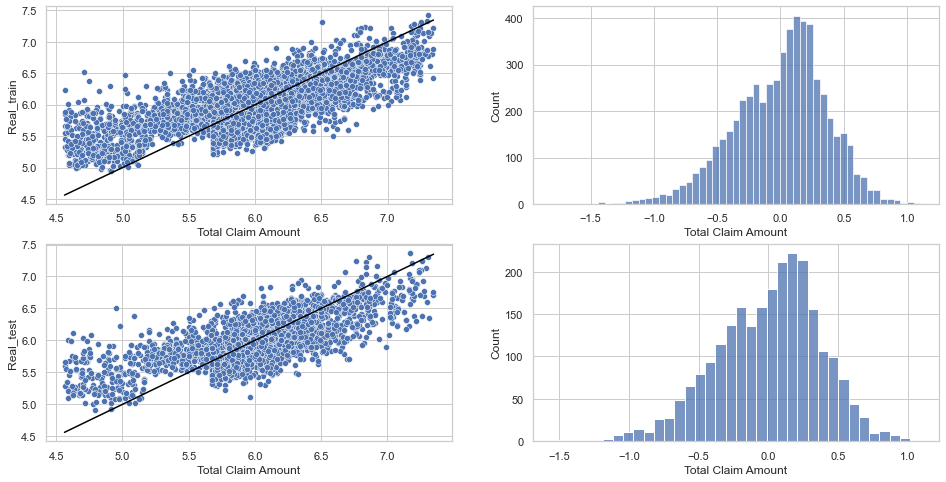

In [38]:
lr_perf_plots(df_train, df_test)